### How to work with ERA5 single levels on Earth Data Hub: climatological analysis of temperature in Germany

***
This notebook will provide you guidance on how to access and use the [`https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-v0.zarr`](https://earthdatahub.com/collections/era5/datasets/reanalysis-era5-single-levels) datset on [Earth Data Hub](https://earthdatahub.com).
***

### What you will learn:
* how to access and preview the dataset
* select and reduce the data
* plot the results
***

Our first goal is to compute the 2 metre temperature anomaly for the month of October 2023, in the Germany area, against the 1991-2020 reference period. 

Our second goal is to compute the 2 metre temperature climatology (monthly means and standard deviations) in Berlin for the same reference period and compare it with the monthly averages of 2023.
***


### Data access and preview
***

[Xarray](https://docs.xarray.dev/en/stable) and [Dask](https://www.dask.org) work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place (e.g., when the `.compute()` or `.plot()` methods are called).

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically:

***

In [18]:
import xarray as xr

ds = xr.open_dataset(
    "https://data.earthdatahub.com/era5/reanalysis-era5-single-levels-v0.zarr",
    chunks={},
    engine="zarr",
    storage_options={"client_kwargs": {"trust_env": True}},
)
ds

ClientResponseError: 401, message='Unauthorized', url=URL('https://data.earthdatahub.com/era5/reanalysis-era5-single-levels-v0.zarr/.zmetadata')

### Working with EDH data

Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment. 

The structure of a workflow that uses EDH data looks like this:
1. data selection
2. (optional) data reduction
3. (optional) visualization

### Average 2 metre temperature in Germany, October 2023

#### 1. Data selection

First, we perform a geographical selection corresponding to the Germany area. This greatly reduces the amount of data that will be downloaded from EDH. Also, we convert the temperature to `°C`.

In [2]:
t2m = ds.t2m.astype("float32") - 273.15
t2m.attrs["units"] = "C"
t2m_germany_area = t2m.sel(**{"latitude": slice(55, 47), "longitude": slice(5, 16)})
t2m_germany_area

<xarray.DataArray 't2m' (valid_time: 736344, latitude: 33, longitude: 45)> Size: 4GB
dask.array<getitem, shape=(736344, 33, 45), dtype=float32, chunksize=(4320, 33, 44), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 264B 55.0 54.75 54.5 ... 47.5 47.25 47.0
  * longitude   (longitude) float64 360B 5.0 5.25 5.5 5.75 ... 15.5 15.75 16.0
    number      int64 8B ...
    surface     float64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6MB 1940-01-01 ... 2023-12-31T23:...
Attributes:
    units:    C

!NB: At this point, no data has been downloaded yet, nor loaded in memory.

Second, we further select the October 2023 month. This is, again, a lazy operation:

In [3]:
t2m_germany_area_october_2023 = t2m_germany_area.sel(valid_time="2023-10")
t2m_germany_area_october_2023

<xarray.DataArray 't2m' (valid_time: 744, latitude: 33, longitude: 45)> Size: 4MB
dask.array<getitem, shape=(744, 33, 45), dtype=float32, chunksize=(480, 33, 44), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 264B 55.0 54.75 54.5 ... 47.5 47.25 47.0
  * longitude   (longitude) float64 360B 5.0 5.25 5.5 5.75 ... 15.5 15.75 16.0
    number      int64 8B ...
    surface     float64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2023-10-01 ... 2023-10-31T23:...
Attributes:
    units:    C

At this point the selection is small enough to call `.compute()` on it. This will trigger the download of data from EDH and load it in memory. 

We can measure the time it takes:

In [4]:
%%time

t2m_germany_area_october_2023 = t2m_germany_area_october_2023.compute()

CPU times: user 1.3 s, sys: 387 ms, total: 1.69 s
Wall time: 27.1 s


The data was very small, this didn't take long.

#### 2. Data reduction

Now that the data is loaded in memory, we can easily compute the october 2023 monthly mean:

In [5]:
t2m_germany_area_october_2023_monthly_mean = t2m_germany_area_october_2023.mean(dim="valid_time")
t2m_germany_area_october_2023_monthly_mean

<xarray.DataArray 't2m' (latitude: 33, longitude: 45)> Size: 6kB
array([[13.325453 , 13.389966 , 13.424911 , ..., 12.257616 , 12.284496 ,
        12.304321 ],
       [13.614086 , 13.664152 , 13.679943 , ..., 12.537507 , 12.4921465,
        12.512643 ],
       [13.858366 , 13.903055 , 13.91448  , ..., 12.575477 , 12.505922 ,
        12.191089 ],
       ...,
       [13.5314245, 14.038129 , 14.431263 , ..., 10.0140505, 10.73885  ,
        11.996536 ],
       [14.110707 , 14.629511 , 15.010548 , ..., 11.550653 , 12.272733 ,
        12.732729 ],
       [14.843212 , 15.05759  , 15.260543 , ..., 13.064035 , 13.677259 ,
        13.871476 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 264B 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude  (longitude) float64 360B 5.0 5.25 5.5 5.75 ... 15.5 15.75 16.0
    number     int64 8B 0
    surface    float64 8B 0.0

#### 3. Visualization
Finally, we can plot the october 2023 montly mean on a map:

In [6]:
import display
import matplotlib.pyplot as plt

<GeoAxes: title={'center': 'Mean Surface Temperature, Oct 2023'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

/Users/nicola/opt/miniconda3/envs/edh/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/nicola/opt/miniconda3/envs/edh/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/nicola/opt/miniconda3/envs/edh/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


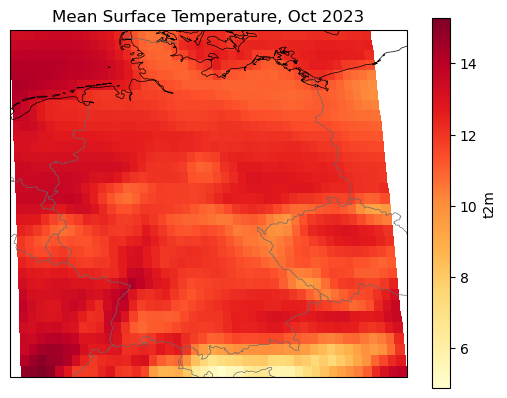

In [7]:
display.map(t2m_germany_area_october_2023_monthly_mean, vmax=None, cmap="YlOrRd", title="Mean Surface Temperature, Oct 2023")

### 2 metre temperature anomaly in Germany, October 2023 

Following the above schema we can compute the 2 metre temperature anomaly for the month of October 2023 against the 1991-2020 reference period, once again in Germany.

We fistly select the relevant months in the reference period:

In [8]:
t2m_germany_area_octobers_1991_2020 = t2m_germany_area.sel(valid_time=t2m_germany_area["valid_time.month"] == 10).sel(valid_time=slice("1991", "2020"))
t2m_germany_area_octobers_1991_2020

<xarray.DataArray 't2m' (valid_time: 22320, latitude: 33, longitude: 45)> Size: 133MB
dask.array<getitem, shape=(22320, 33, 45), dtype=float32, chunksize=(744, 33, 44), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 264B 55.0 54.75 54.5 ... 47.5 47.25 47.0
  * longitude   (longitude) float64 360B 5.0 5.25 5.5 5.75 ... 15.5 15.75 16.0
    number      int64 8B ...
    surface     float64 8B ...
  * valid_time  (valid_time) datetime64[ns] 179kB 1991-10-01 ... 2020-10-31T2...
Attributes:
    units:    C

This is small enought to be computed in reasonable time:

In [9]:
%%time

t2m_germany_area_octobers_1991_2020 = t2m_germany_area_octobers_1991_2020.compute()

CPU times: user 18.4 s, sys: 4.9 s, total: 23.3 s
Wall time: 3min 33s


Now that the data is loaded in memory we can esily compute the 1991-2020 octobers mean:

In [10]:
t2m_germany_area_octobers_1991_2020_mean = t2m_germany_area_octobers_1991_2020.mean(dim="valid_time")

And finally the anomaly:

In [11]:
anomaly = t2m_germany_area_october_2023_monthly_mean - t2m_germany_area_octobers_1991_2020_mean
anomaly

<xarray.DataArray 't2m' (latitude: 33, longitude: 45)> Size: 6kB
array([[0.94561386, 0.9775305 , 0.9818058 , ..., 1.1062622 , 1.1509447 ,
        1.18295   ],
       [1.058692  , 1.0717936 , 1.0788851 , ..., 1.3152046 , 1.3094378 ,
        1.3461571 ],
       [1.1612654 , 1.169033  , 1.1861801 , ..., 1.4496317 , 1.4415836 ,
        1.3800087 ],
       ...,
       [2.637679  , 2.6654654 , 2.8324194 , ..., 3.3936133 , 3.5344958 ,
        3.6796694 ],
       [2.7071152 , 2.7365713 , 2.8895226 , ..., 3.2909975 , 3.426055  ,
        3.5746298 ],
       [2.8477697 , 2.828455  , 2.91681   , ..., 3.4293985 , 3.4998322 ,
        3.638671  ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 264B 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude  (longitude) float64 360B 5.0 5.25 5.5 5.75 ... 15.5 15.75 16.0
    number     int64 8B 0
    surface    float64 8B 0.0

We can plot the anomaly on a map:

<GeoAxes: title={'center': 'Mean Surface Temperature anomaly (ref 1991-2020), Oct 2013'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

/Users/nicola/opt/miniconda3/envs/edh/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/nicola/opt/miniconda3/envs/edh/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/nicola/opt/miniconda3/envs/edh/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


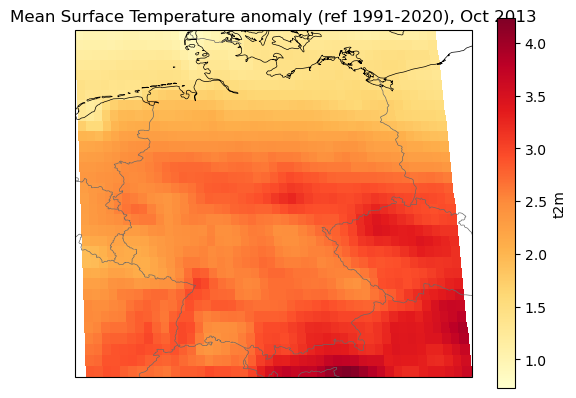

In [12]:
display.map(
    anomaly,
    vmax=None, 
    cmap="YlOrRd", 
    title="Mean Surface Temperature anomaly (ref 1991-2020), Oct 2013"
)

### 2 metre temperature climatology (1991-2020) in Berlin vs 2023 montly mean

We will now compute the 2 metre temperature climatology (montly mean and standard deviation) in Berlin, over the reference period 1991-2020, and compare it with the 2023 monthly means.

We first select the closet data to Berlin:

In [13]:
%%time

t2m_Berlin = t2m.sel(**{"latitude": 52.5, "longitude": 13.4}, method="nearest")
t2m_Berlin

CPU times: user 2.92 ms, sys: 1.22 ms, total: 4.14 ms
Wall time: 1.17 ms


<xarray.DataArray 't2m' (valid_time: 736344)> Size: 3MB
dask.array<getitem, shape=(736344,), dtype=float32, chunksize=(4320,), chunktype=numpy.ndarray>
Coordinates:
    latitude    float64 8B 52.5
    longitude   float64 8B 13.5
    number      int64 8B ...
    surface     float64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6MB 1940-01-01 ... 2023-12-31T23:...
Attributes:
    units:    C

This is already small enought to be computed:

In [14]:
%%time

t2m_Berlin = t2m_Berlin.compute()

CPU times: user 1min 2s, sys: 16.4 s, total: 1min 18s
Wall time: 10min 13s


Now that the data is loaded in memory we can easily compute the climatology for the reference period 1991-2020:

In [15]:
t2m_Berlin_climatology_mean = t2m_Berlin.sel(valid_time=slice("1991", "2020")).groupby("valid_time.month").mean(dim="valid_time")
t2m_Berlin_climatology_std = t2m_Berlin.sel(valid_time=slice("1991", "2020")).groupby("valid_time.month").std(dim="valid_time")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


We also compute the  monthly means for the year 2023:

In [16]:
t2m_Berlin_2023_monthly_means = t2m_Berlin.sel(valid_time="2023").resample(valid_time="1M").mean(dim="valid_time")
t2m_Berlin_2023_monthly_means

/Users/nicola/opt/miniconda3/envs/edh/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


<xarray.DataArray 't2m' (valid_time: 12)> Size: 48B
array([ 4.1796923,  3.010704 ,  5.551641 ,  7.8618503, 13.801259 ,
       19.066559 , 19.860262 , 19.305855 , 18.504393 , 11.931021 ,
        5.609091 ,  3.6396573], dtype=float32)
Coordinates:
    latitude    float64 8B 52.5
    longitude   float64 8B 13.5
    number      int64 8B 0
    surface     float64 8B 0.0
  * valid_time  (valid_time) datetime64[ns] 96B 2023-01-31 ... 2023-12-31
Attributes:
    units:    C

We can finally plot the climatology in Berlin for the 1991-2020 refrence period against the 2023 montly means:

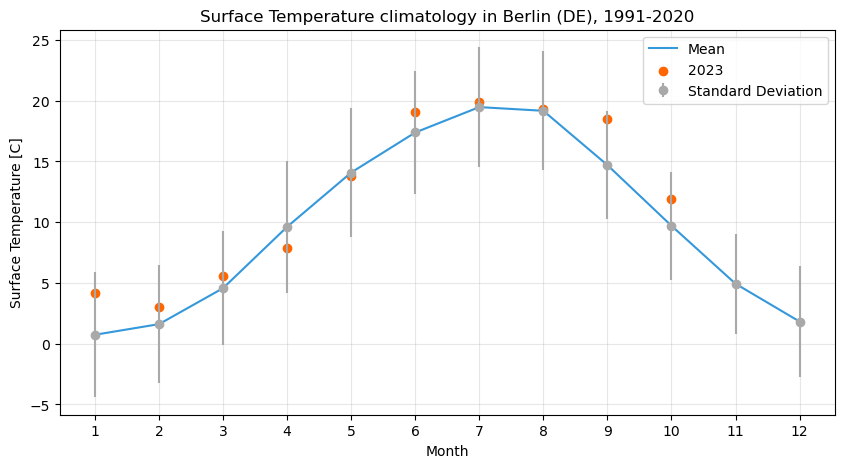

In [17]:
plt.figure(figsize=(10, 5))
t2m_Berlin_climatology_mean.plot(label="Mean", color="#3498db")
plt.errorbar(
    t2m_Berlin_climatology_mean.month, 
    t2m_Berlin_climatology_mean, 
    yerr=t2m_Berlin_climatology_std, 
    fmt="o", 
    label="Standard Deviation",
    color="#a9a9a9"
)
for month in range (1, 11):
    t2m_point = t2m_Berlin_2023_monthly_means.sel(valid_time=t2m_Berlin_2023_monthly_means["valid_time.month"]==month)
    label = None
    if month == 1:
        label = "2023"
    plt.scatter(month, t2m_point, color="#ff6600", label=label)
plt.title("Surface Temperature climatology in Berlin (DE), 1991-2020")
plt.xticks(t2m_Berlin_climatology_mean.month)
plt.xlabel("Month")
plt.ylabel("Surface Temperature [C]")
plt.legend()
plt.grid(alpha=0.3)
plt.show()